In [1]:
import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
#print(os.getcwd())
from codes.experimentclasses.RigidEthanolXYZ import RigidEthanolXYZ
#from codes.otherfunctions.multirun import get_coeffs_reps
#from codes.otherfunctions.multirun import get_grads_reps_pca2
#from codes.otherfunctions.multiplot import plot_betas, plot_betas2reorder
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.flasso.Replicate import Replicate

In [2]:
from codes.experimentclasses.AtomicRegression import AtomicRegression
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.data_stream import data_stream
from codes.geometer.ShapeSpace import compute3angles
import numpy as np
import torch
import math
from sklearn.decomposition import TruncatedSVD
from pathos.multiprocessing import ProcessingPool as Pool


class RigidEthanolXYZ(AtomicRegression):
    """
    This class estimates
    Parameters
    ----------
    filename : string,
        Data file to load
    ii : np.array(dtype = int),
        List of adjacencies
    jj : np.array,
        List of adjacencies part 2
    d : int,
        dimension over which to evaluate the radii (smaller usually better)
    rmin : float,
        smallest radius ( = rad_bw_ratio * bandwidth) to consider
    rmax : float,
        largest radius ( = rad_bw_ratio * bandwidth) to consider
    ntry : int,
        number of radii between rmax and rmin to try
    run_parallel : bool,
        whether to run the analysis in parallel over radii
    search_space : str,
        either 'linspace' or 'logspace', choose to search in log or linear space
    rad_bw_ratio : float,
        the ratio of radius and kernel bandwidth, default to be 3 (radius = 3*h)
    Methods
    -------
    load_data :
        Loads filename as AtomicRegression.data
    get_atoms_4 :
    	Gets atomic tetrahedra based off of ii and jj
    get_atoms_3 :
    	Gets triples of atoms

    """

    # AtomicRegression(dim, ii, jj, filename)
    def __init__(self, dim, cor, xvar, cores, noise, custom_bonds=None ):
        # def __init__(self, r, R, p,n,d, selectedpoints, dim):
        # self.ii = ii
        # self.jj = jj
        self.n = 10000
        self.natoms = 9
        self.cor = cor
        self.cores = cores
        self.noise = noise
        # n_atoms = len(np.unique(ii))
        self.xvar = xvar
        #self.atoms4, self.p = self.get_atoms_4()
        self.d = 27
        # self.atoms3, self.d = self.get_atoms_3(natoms)
        # self.selectedpoints = selectedpoints
        self.dim = dim
        if custom_bonds.any() != None:
            self.atoms4 = custom_bonds
            self.p = custom_bonds.shape[0]
        # self.n = n

    def load_data(self, angles=False):
        # filename = 'tolueneangles.npz'
        n = self.n
        d = self.d
        dim = self.dim
        cor = self.cor
        natoms = self.natoms
        xvar = self.xvar
        cores = self.cores

        positions = np.zeros((n, natoms, 3))
        positions[0,0,:] = np.asarray([0.,0.,0.])
        positions[0,1,:] = np.asarray([-10.,0.,np.sqrt(2)/100])
        positions[0,2,:] = np.asarray([0.,10.,np.sqrt(3)/100])
        #positions[0,8,:] = np.asarray([1.,1.,0.])
        positions[0,8,:] = np.asarray([1.,10.,np.sqrt(5)/100])
        positions[0,3,:] = np.asarray([np.sqrt(7)/100, np.cos(2/3 * np.pi), np.sin(2/3 * np.pi)])
        positions[0,4,:] = np.asarray([np.sqrt(11)/100, np.cos(2/3 * np.pi), np.sin(4/3 * np.pi)])
        positions[0,5,:] = np.asarray([-11.,1.,np.sqrt(13)/100])
        positions[0,6,:] = np.asarray([-11., np.cos(2/3 * np.pi),np.sin(2/3 * np.pi)])
        positions[0,7,:] = np.asarray([-11.,np.cos(2/3 * np.pi), np.sin(4/3 * np.pi)])
        angles1 = np.tile(np.linspace(start=0., stop=2 * math.pi, num=int(np.sqrt(n)), endpoint=False), int(np.sqrt(n)))
        angles2 = np.repeat(np.linspace(start=0., stop=2 * math.pi, num=int(np.sqrt(n)), endpoint=False),
                            int(np.sqrt(n)))
        for i in range(1, n):
            #     rotationmatrix1 = np.zeros((3,3))
            #     rotationmatrix1[0,0] = 1
            #     rotationmatrix1[1,1] = np.cos(angles1[i])
            #     rotationmatrix1[1,2] = -np.sin(angles1[i])
            #     rotationmatrix1[2,2] = np.cos(angles1[i])
            #     rotationmatrix1[2,1] = np.sin(angles1[i])

            rotationmatrix1 = np.zeros((3, 3))
            rotationmatrix1[1, 1] = 1
            rotationmatrix1[0, 0] = np.cos(angles1[i])
            rotationmatrix1[0, 2] = -np.sin(angles1[i])
            rotationmatrix1[2, 2] = np.cos(angles1[i])
            rotationmatrix1[2, 0] = np.sin(angles1[i])

            rotationmatrix2 = np.zeros((3, 3))
            rotationmatrix2[0, 0] = 1
            rotationmatrix2[1, 1] = np.cos(angles2[i])
            rotationmatrix2[1, 2] = -np.sin(angles2[i])
            rotationmatrix2[2, 2] = np.cos(angles2[i])
            rotationmatrix2[2, 1] = np.sin(angles2[i])
            positions[i, np.asarray([3, 4]), :] = positions[0, np.asarray([3, 4]), :]
            positions[i, np.asarray([2, 8]), :] = np.matmul(rotationmatrix1,
                                                            positions[0, np.asarray([2, 8]), :].transpose()).transpose()
            positions[i, np.asarray([1, 5, 6, 7]), :] = np.matmul(rotationmatrix2,
                                                                  positions[0, np.asarray([1, 5, 6, 7]),
                                                                  :].transpose()).transpose()

        print(positions[0])
        covariance = np.identity(natoms)
        for i in range(natoms):
            for j in range(natoms):
                if i != j:
                    covariance[i, j] = cor
        # covariance = xvar * covariance
        # for i in range(n):
        #    for j in range(3):
        #        positions[i,:,j] = np.random.multivariate_normal(positions[i,:,j], covariance,size = 1)
        self.positions = positions

        print(positions[0])
        if angles == True:
            p = Pool(cores)
            results = p.map(lambda i: compute3angles(position=positions[i[0], atoms3[i[1]], :]), data_stream(10000, 84))
            data = np.reshape(results, (n, (d)))
        else:
            data = np.reshape(positions, (n, d))
        return (RiemannianManifold(data, dim))


    def get_dx_g_full(self, data):

        n = data.shape[0]
        d = self.d
        p = self.p
        output = np.zeros((n, p, d))
        for i in range(n):
            # if angles == True:
            #     pass
            # else:
            output[i, :, :] = self.get_dx_g_xyz(data[i]).transpose()
        return (output)

    #     def get_dx_g_pos_pytorch_full(self,data):
    #         n = data.shape[0]
    #         d = self.d
    #         p = self.p
    #         output = np.zeros((n,p,d))
    #         for i in range(n):
    #             output[i,:,:] = self.get_dx_g_pos_pytorch(data[i]).transpose()
    #         return(output)
    def get_g(self, x):
        atoms4 = self.atoms4
        # atoms3 = self.atoms3
        # p = len(atoms4)
        p = self.p
        # combos = np.asarray([[0,1,2],[1,2,3],[0,2,3],[0,1,3]])
        # d = atoms3.shape[0] * 3
        d = self.d
        output = np.zeros((p))
        # loop over tetrehedra
        for k in range(p):
            atom4 = atoms4[k, :]
            x4 = np.zeros((4, 3))
            for i in range(4):
                x4[i, :] = x[(atom4[i] * 3):(atom4[i] * 3 + 3)]
            x4 = np.asarray(x4)
            fitin = self.g4(x4, True)
            output[k] = fitin[0]
        return (output)

    def get_g_full(self, data):
        n = data.shape[0]
        p = self.p
        output = np.zeros((n, p))
        for i in range(n):
            # if angles == True:
            #     pass
            # else:
            output[i, :] = self.get_g(data[i]).transpose()
        return (output)

    def get_dx_g_xyz(self, x):
        atoms4 = self.atoms4
        # atoms3 = self.atoms3
        # p = len(atoms4)
        p = self.p
        # combos = np.asarray([[0,1,2],[1,2,3],[0,2,3],[0,1,3]])
        # d = atoms3.shape[0] * 3
        d = self.d
        output = np.zeros((d, p))
        # loop over tetrehedra
        for k in range(p):
            atom4 = atoms4[k, :]
            x4 = np.zeros((4, 3))
            for i in range(4):
                x4[i, :] = x[(atom4[i] * 3):(atom4[i] * 3 + 3)]
            x4 = np.asarray(x4)
            fitin = self.g4(x4, True)
            for i in range(4):
                # a = atoms3[actived[i]]
                for j in range(3):
                    # plus the lowest index first
                    output[3 * atom4[i] + j, k] = fitin[1][i, j]
        return (output)

    # need to check range of arccos
    def positions_to_torsion(self, positions4):
        positions4 = torch.tensor(positions4, requires_grad=True)
        d1 = positions4[0]
        c1 = positions4[1]
        c2 = positions4[2]
        d2 = positions4[3]
        cc = c2 - c1
        ip = torch.sum((d1 - c1) * (c2 - c1)) / (torch.sum((c2 - c1) ** 2))
        tilded1 = [d1[0] - ip * cc[0], d1[1] - ip * cc[1], d1[2] - ip * cc[2]]
        iq = torch.sum((d2 - c2) * (c1 - c2)) / (torch.sum((c1 - c2) ** 2))
        cc2 = (c1 - c2)
        tilded2 = [d2[0] - iq * cc2[0], d2[1] - iq * cc2[1], d2[2] - iq * cc2[2]]
        tilded2star = [tilded2[0] + cc2[0], tilded2[1] + cc2[1], tilded2[2] + cc2[2]]
        ab = torch.sqrt((tilded2star[0] - c1[0]) ** 2 + (tilded2star[1] - c1[1]) ** 2 + (tilded2star[2] - c1[2]) ** 2)
        bc = torch.sqrt((tilded2star[0] - tilded1[0]) ** 2 + (tilded2star[1] - tilded1[1]) ** 2 + (
                    tilded2star[2] - tilded1[2]) ** 2)
        ca = torch.sqrt((tilded1[0] - c1[0]) ** 2 + (tilded1[1] - c1[1]) ** 2 + (tilded1[2] - c1[2]) ** 2)
        output = torch.acos((ab ** 2 - bc ** 2 + ca ** 2) / (2 * ab * ca))
        return (output)

    def g4(self, positions4, grad=True):
        positions4 = torch.tensor(positions4, requires_grad=True)
        torsion = self.positions_to_torsion(positions4)
        torsion.backward(retain_graph=True)
        return (torsion, positions4.grad)

 

In [3]:
n = 10000
natoms = 9
n_components = 3
itermax = 10000
tol = 1e-10
lambdas = np.asarray([0.,0.0001,.001,.01,.1,1,10,100], dtype = np.float16)
nsel = 25
#sample_pts = np.random.choice(list(range(n)),nsel,replace = False)
n_neighbors = 100
#nsample = len(sample_pts)
diffusion_time = .05
dim = 2
#filename = '/Users/samsonkoelle/Desktop/NIPScode2018/ethanolangles.npz'
filename = 'doesntmatter'
cor = 0.
noise = False
var= 0.00001
cores = 3
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)
experiment = RigidEthanolXYZ(dim, cor,var, cores, noise, atoms4)
#experiment = RigidEthanolXYZ(dim, 9,n,0.0,0.0001)
experiment.M = experiment.load_data()
experiment.M.geom = experiment.M.compute_geom_brute(diffusion_time = diffusion_time, n_neighbors = n_neighbors)
#experiment.M.geom = experiment.M.compute_geom(diffusion_time = diffusion_time, n_neighbors = n_neighbors)


[[  0.           0.           0.        ]
 [-10.           0.           0.01414214]
 [  0.          10.           0.01732051]
 [  0.02645751  -0.5          0.8660254 ]
 [  0.03316625  -0.5         -0.8660254 ]
 [-11.           1.           0.03605551]
 [-11.          -0.5          0.8660254 ]
 [-11.          -0.5         -0.8660254 ]
 [  1.          10.           0.02236068]]
[[  0.           0.           0.        ]
 [-10.           0.           0.01414214]
 [  0.          10.           0.01732051]
 [  0.02645751  -0.5          0.8660254 ]
 [  0.03316625  -0.5         -0.8660254 ]
 [-11.           1.           0.03605551]
 [-11.          -0.5          0.8660254 ]
 [-11.          -0.5         -0.8660254 ]
 [  1.          10.           0.02236068]]
initializing Geometry


/Users/samsonkoelle/anaconda3/envs/py35021518/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/Users/samsonkoelle/anaconda3/envs/py35021518/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [4]:
experiment.N = experiment.M.get_embedding3(experiment.M.geom, n_components, diffusion_time, 2)


executing laplacian.compute_laplacian_matrix
executing Laplacian.laplacian_matrix
pre _compute_laplacian
executing GeometricLaplacian._compute_laplacian
executing _normalize_laplacian
executing _normalize_laplacian
post _compute_laplacian


/Users/samsonkoelle/anaconda3/envs/py35021518/lib/python3.5/site-packages/megaman/geometry/rmetric.py:95: RuntimeWarning: divide by zero encountered in reciprocal
  Einv = E**(-1)


In [7]:
nreps = 25
# selected_points_save = np.zeros((nreps,nsel))
from codes.otherfunctions.get_dictionaries import get_atoms_4
ii = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj = np.asarray([1,2,3,4,5,6,7,8])
experiment.atoms4, experiment.p = get_atoms_4(9,ii,jj)
experiment.q  = 3
# nsel = 100
# from codes.geometer.ShapeSpace import ShapeSpace
# from codes.geometer.TangentBundle import TangentBundle


# # def get_grads3(experiment, Mpca, Mangles, N, selected_points,svd):

# #     dimnoise = experiment.dnoise
# #     dim = experiment.dim
# #     cores = experiment.cores

# #     tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
# #     subM = RiemannianManifold(Mpca.data[selected_points], dim)
# #     subM.tb = TangentBundle(subM, tangent_bases)
# #     N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

# #     df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
# #     #n = len(selected_points)
# #     df_M2 = experiment.normalize(df_M)
# #     dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])
# #     W = ShapeSpace(experiment.positions, Mangles.data)
# #     dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
# #     dg_w = experiment.project(np.swapaxes(dw, 1, 2),
# #                               experiment.project(dw, dg_x))
# #     dg_w_pca = np.asarray([svd.transform(dg_w[j]) for j in range(len(selected_points))])
# #     dgw_norm = experiment.normalize(dg_w_pca)
# #     dg_M = np.einsum('n b d, n p b -> n p d', subM.tb.tangent_bases, dgw_norm) #experiment.project(subM.tb.tangent_bases, dgw_norm)
# #     return (df_M2, dg_M, dg_w, dg_w_pca, dgw_norm,tangent_bases)


# def get_grads(self, M, N , selected_points):
#     dimnoise = 2
#     tangent_bases = self.M.get_wlpca_tangent_sel(M, selected_points)
#     subM = RiemannianManifold(M.data[selected_points], dim)
#     subM.tb = TangentBundle(subM, tangent_bases)
#     N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))
#     df_M = self.get_dF_js_idM(M, N, subM.tb, N.tangent_bundle,selected_points,dimnoise)        #experiments[i].df_M = experiments[i].df_M / np.linalg.norm(experiments[i].df_M, axis=1).sum(axis=0)
#     #df_M2 = df_M / np.linalg.norm(df_M) ** 2
#     df_M2 = experiment.normalize(df_M)
#     dg_x = self.get_dx_g_full(M.data[selected_points])
#     #W = ShapeSpace(self.positions, M.data)
#     #dw = W.get_dw(cores, self.atoms3, self.natoms, selected_points)
#     #dg_w = self.project(np.swapaxes(dw, 1, 2),self.project(dw, dg_x))
#     dgx_norm = self.normalize(dg_x)
#     #dg_M = self.project(subM.tb.tangent_bases, dgx_norm)
#     dg_M = np.einsum('n b d, n p b -> n p d', subM.tb.tangent_bases, dgx_norm) #experiment.project(subM.tb.tangent_bases, dgw_norm)
#     return(df_M2, dg_M)

from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle

def get_grads(self, M, N , selected_points):
    dimnoise = 2
    tangent_bases = self.M.get_wlpca_tangent_sel(M, selected_points)
    subM = RiemannianManifold(M.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, N.geom.rmetric.embedding_eigenvectors)
    df_M = self.get_dF_js_idM(M, N, subM.tb, N.tangent_bundle,selected_points,dimnoise)        #experiments[i].df_M = experiments[i].df_M / np.linalg.norm(experiments[i].df_M, axis=1).sum(axis=0)
    df_M2 = df_M / np.linalg.norm(df_M) ** 2
    dg_x = self.get_dx_g_full(M.data[selected_points])
    #W = ShapeSpace(self.positions, M.data)
    #dw = W.get_dw(cores, self.atoms3, self.natoms, selected_points)
    #dg_w = self.project(np.swapaxes(dw, 1, 2),self.project(dw, dg_x))
    dgx_norm = self.normalize(dg_x)
    dg_M = self.project(subM.tb.tangent_bases, dgx_norm)
    return(df_M2, dg_M)



In [8]:
print('pre-gradient acquisition')
replicates = {}
print(datetime.datetime.now())
nreps = 25
selected_points_save = np.zeros((nreps,nsel))
for i in range(nreps):#nreps):
    print(i)
    selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates[i] = Replicate(nsel = nsel, selected_points = selected_points)
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M = get_grads(experiment, experiment.M, experiment.N, selected_points)
    replicates[i].dg_M = np.swapaxes(replicates[i].dg_M, 1,2)

pre-gradient acquisition
2021-05-07 15:44:03.897910
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [9]:
experiment.M.data.shape

(10000, 27)

In [10]:
from codes.otherfunctions.get_cosines import get_cosines
import matplotlib.pyplot as plt
from codes.plotting.cosines import plot_cosines
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

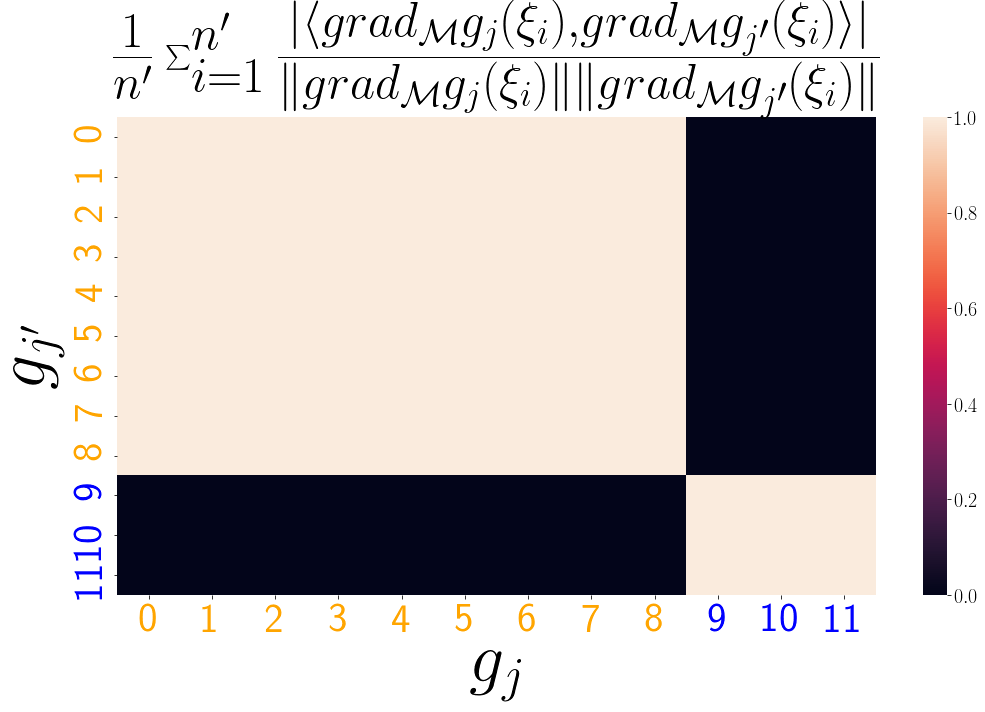

In [41]:
cosine = get_cosines(np.swapaxes(replicates[0].dg_M,1,2))
cosine_abs = np.mean(np.abs(cosine), axis = 0)
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

#[ax.set_axis_off() for ax in axarr.ravel()]
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_cosines(cosine_abs, axes_all, colors)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re12_xyz_cosines')
#mal_cosine = get_cosines(np.swapaxes(replicates_malonaldehyde[0].dg_M,1,2))

In [12]:
from codes.plotting.supportrecovery import plot_watch3,plot_reg_path_ax_lambdasearch_customcolors_norm

In [13]:
from einops import rearrange
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel


In [14]:
gl_itermax = 100
p  = experiment.p
lambdas_start = [0., 0.56]
#lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-16
learning_rate = 1

from pathos.multiprocessing import ProcessingPool as Pool
#from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel

print('pre-gradient descent')
print(datetime.datetime.now())
cores = 16
# pcor = Pool(cores)
# results = pcor.map(lambda replicate: get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate), batch_stream(replicates))

results = {}
for r in range(nreps):#nreps):
    print(r)
    #results[r] = Replicate()
    replicates[r].results = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


pre-gradient descent
2021-05-07 15:44:15.897950
0
initializing lambda search
converged 0.56
0 0.28 probe
converged 0.28
1 0.14 probe
we did it [6 9]
1
initializing lambda search
converged 0.56
0 0.28 probe
1 0.14 probe
we did it [6 9]
2
initializing lambda search
converged 0.56
0 0.28 probe
converged 0.28
1 0.14 probe
we did it [6 9]
3
initializing lambda search
converged 0.56
0 0.28 probe
converged 0.28
1 0.14 probe
we did it [6 9]
4
initializing lambda search
converged 0.56
0 0.28 probe
1 0.14 probe
we did it [6 9]
5
initializing lambda search
converged 0.56
0 0.28 probe
converged 0.28
1 0.14 probe
we did it [6 9]
6
initializing lambda search
converged 0.56
0 0.28 probe
converged 0.28
1 0.14 probe
we did it [6 9]
7
initializing lambda search
0 0.28 probe
we did it [6 9]
8
initializing lambda search
converged 0.56
0 0.28 probe
converged 0.28
1 0.14 probe
we did it [6 9]
9
initializing lambda search
converged 0.56
0 0.28 probe
1 0.14 probe
we did it [6 9]
10
initializing lambda search


In [15]:
#nreps = 25
sel_l = np.zeros(nreps, dtype = int)
sel = {}
for r in range(nreps):
    cs = rearrange(np.asarray(list(replicates[r].results[1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(replicates[r].results[1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis
    
    sel_l[r] = np.where(xaxis_reorder ==  replicates[r].results[0])[0][0]
    sel[r] = np.where(np.linalg.norm(replicates[r].cs_reorder, axis = tuple([1,2,]))[sel_l[r]] !=0.)[0]

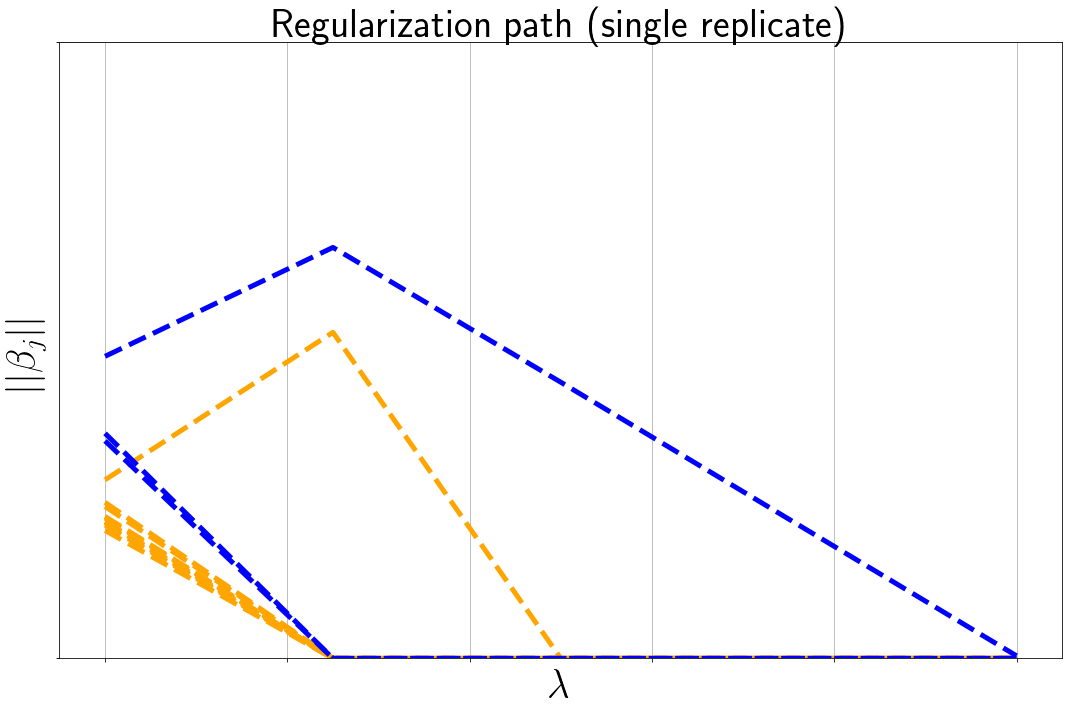

In [42]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder / replicates[0].xaxis_reorder.max(), fig,colors)#axes_all[0].imshow(asdf)
axes_all.set_title('Regularization path (single replicate)', fontsize = 40)
axes_all.set_ylabel(r'$||\beta_j||$', fontsize = 40)
axes_all.set_xlabel(r'$\lambda$', fontsize = 40)
axes_all.set_xticklabels([])
axes_all.set_yticklabels([])
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re12_xyz_rep')

In [17]:
#sel_eth = {}
toplot = np.zeros((12,12))
for r in range(nreps):
    zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    toplot[sel[r][0], sel[r][1]] += 1
    toplot[sel[r][1], sel[r][0]] += 1

In [18]:
#sel_eth = {}
toplot = np.zeros((12,12))
for r in range(nreps):
    zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    toplot[sel[r][0], sel[r][1]] += 1
    toplot[sel[r][1], sel[r][0]] += 1

In [19]:
from codes.plotting.supportrecovery import plot_watch_custom

In [25]:

def plot_watch_custom(to_plot, p, ax, colors,nreps):

    # fig, ax = plt.subplots(figsize = (15,15))
    # %matplotlib inline

    # fig, ax = plt.subplots(figsize = (15,15))
    theta = np.linspace(0, 2 * np.pi, 10000)
    cmap = plt.get_cmap('viridis', p)

    angles = np.linspace(0, 2 * np.pi, p + 1)

    radius = 1.

    a = radius * np.cos(theta)
    b = radius * np.sin(theta)

    # figure, axes = plt.subplots(figsize = (15,15))

    # axes.plot(a, b, color= 'gray')
    ax.scatter(a, b, color='gray', s=.2,
               alpha=.1)  # , '-', color = 'gray')#, s= .1, alpha = .1)#, type = 'line')#,cmap=plt.get_cmap('twilight')) #'hsv','twilight_shifted

    # for i in range(to_plot.shape)
    if len(to_plot.shape) > 1:
        totes = np.sum(to_plot, axis=0)
    else:
        totes = to_plot

    for j in range(p):
        print(np.cos(angles[j]), np.sin(angles[j]))  # r'$test \frac{1}{}$'.format(g)
        ax.scatter(np.cos(angles[j]), np.sin(angles[j]), color=cmap.colors[j], marker='x')
        ax.text(x=1.1 * np.cos(angles[j]),
                y=1.1 * np.sin(angles[j]),
                s=r"$g_{{{}}}$".format(j), color=colors[j],  # cmap.colors[j],
                fontdict={'fontsize': 70},
                horizontalalignment='center',
                verticalalignment='center')

        ax.text(x=.9 * np.cos(angles[j]), y=.9 * np.sin(angles[j]), s=str(totes[j] / nreps), fontdict={'fontsize': 40},
                horizontalalignment='center',
                verticalalignment='center')

    for j in range(p):
        ax.scatter(np.cos(angles[j]), np.sin(angles[j]), color=colors[j], marker='o', s=200 * totes[j])

    if len(to_plot.shape) > 1:
        for i in range(p):
            for j in range(p):

                # point1 = [1, 2]
                # point2 = [3, 4]

                x_values = [np.cos(angles[j]), np.cos(angles[i])]
                # gather x-values

                y_values = [np.sin(angles[j]), np.sin(angles[i])]
                # gather y-values

                ax.plot(x_values, y_values, linewidth=to_plot[i, j], color='black')

                if to_plot[i, j] > 0:
                    ax.text(x=np.mean(x_values),
                            y=np.mean(y_values),
                            s=str(to_plot[i, j] / nreps),
                            fontdict={'fontsize': 40})  # ,
                # horizontalalignment='left',
                # verticalalignment='bottom')

                # axes.axline((x1, y1), (x2, y2))
    ax.set_aspect(1)
    ax.set_axis_off()
    ax.set_title(r"$\omega = 25$")



1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004


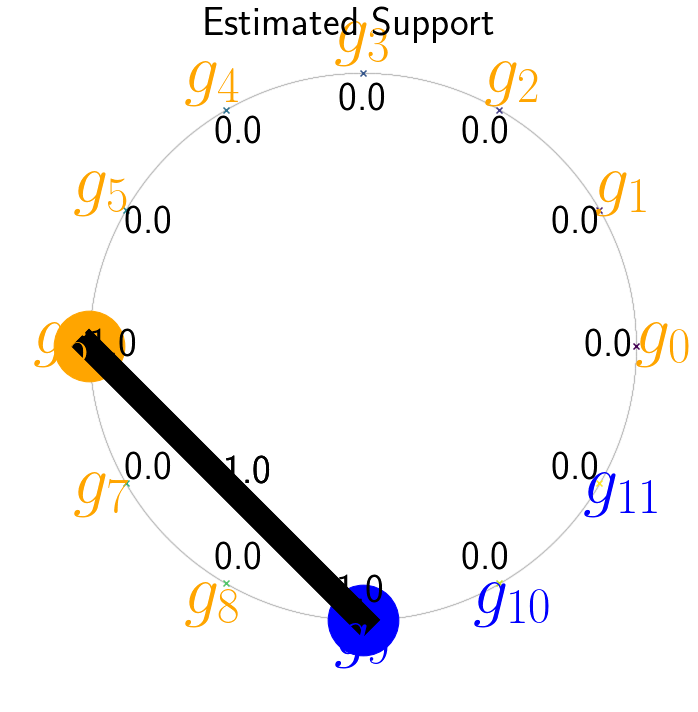

In [43]:
fig, axes_all = plt.subplots(figsize=(15, 10))

#[ax.set_axis_off() for ax in axarr.ravel()]
#colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_watch_custom(toplot, 12, axes_all,colors, nreps)
axes_all.set_title('Estimated Support', fontsize = 40)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/re12_xyz_watch')

In [30]:
from codes.experimentclasses.RigidEthanolPCA3 import get_rigid_ethanol_data
atoms3, da = experiment.get_atoms_3()

In [35]:
data_angles, positions  =  get_rigid_ethanol_data(cor = 0., xvar = 0., cores = 3, atoms3 = atoms3, noise = False)
Mangles = RiemannianManifold(data_angles, dim)#experiment.load_data(workingdirectory = data_wd)
#experiment = AtomicRegression(natoms)
experiment.atoms3 = atoms3

In [36]:
ii_eth = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj_eth = np.asarray([1,2,3,4,5,6,7,8])
atoms4_eth,p = get_atoms_4(9,ii_eth,jj_eth)
g1 = experiment.get_g_full_sub(Mangles.data, atoms4_eth[0])
g2 = experiment.get_g_full_sub(Mangles.data, atoms4_eth[9])

AttributeError: 'tuple' object has no attribute 'transpose'

In [40]:
g1 = experiment.get_g_full_sub(Mangles.data, atoms4_eth[0])

AttributeError: 'tuple' object has no attribute 'transpose'